# Comparison of calculated CS for deactivated and inactivated states


In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy 
import os
import re
import MDAnalysis
import nmrglue as ng
%matplotlib inline

In [2]:
# read deaactivate data
#data paht:/scripts/QM_analysis/KcsA_Deactivated_df_MMQM_CS_torsion.csv
deactivate_data_path = '/Users/yunyao_1/Dropbox/KcsA/scripts/QM_analysis/KcsA_Deactivated_df_MMQM_CS_torsion.csv'
# inactivated data path: 'scripts/QM_analysis/KcsA_Inactivated_df_MMQM_CS_torsion.csv'
# no index column in the csv files
deactivate_data = pd.read_csv(deactivate_data_path)
# read inactivated data
inactivated_data_path = '/Users/yunyao_1/Dropbox/KcsA/scripts/QM_analysis/KcsA_Inactivated_df_MMQM_CS_torsion.csv'
inactivated_data = pd.read_csv(inactivated_data_path)


In [5]:
# check data so that the data is read correctly
print(deactivate_data['resNO'].unique())
print(inactivated_data['resNO'].unique())
# check the data types
print(deactivate_data.head())

[ 50  51  52  53  54  55  56  57  58  59  60 153 154 155 156 157 158 159
 160 161 162 163 256 257 258 259 260 261 262 263 264 265 266 359 360 361
 362 363 364 365 366 367 368 369]
[ 46  47  48  49  50  51  52  53  54  55  56 142 143 144 145 146 147 148
 149 150 151 152 238 239 240 241 242 243 244 245 246 247 248 334 335 336
 337 338 339 340 341 342 343 344]
   resNO atom resNam      iso    delta    ita    alpha    betta    gamma  \
0     50    C    GLU  176.730   81.275  0.949   15.152  -68.205   92.262   
1     51    N    THR  114.821  107.043  0.126   19.136  172.946  186.454   
2     51    H    THR    5.738    5.697  0.434   21.765   29.074   31.548   
3     51   CA    THR   72.823  -23.743  0.142  103.419  106.794  140.720   
4     51   HA    THR    3.922    1.965  0.436   27.313   29.831   30.688   

   frame  residue  torsion_angle_phi  torsion_angle_psi  
0      0       50         -76.592973         -36.245146  
1      0       51         -71.587196         -34.163796  
2      0 

In [ ]:
# seperate the deactivate data into two parts, one for flip, ome for no flip
# flip state: torson angle of V76 > - 25
# add a new column to indicate the flip state


In [14]:
#extract V76 and G77 for Deactivated state
import matplotlib.pyplot as plt

# Define indices for residues
G77_index = [77 - 22 + n * 103 + 1 for n in range(4)]
V76_index = [76 - 22 + n * 103 + 1 for n in range(4)]

# Filter rows for V76 and exclude rows where 'atom' starts with 'H'
V76_df_de = deactivate_data[
    deactivate_data['resNO'].isin(V76_index) & 
    (~deactivate_data['atom'].astype(str).str.startswith('H'))
].copy()

# Filter rows for G77 and exclude rows where 'atom' starts with 'H'
G77_df_de = deactivate_data[
    deactivate_data['resNO'].isin(G77_index) & 
    (~deactivate_data['atom'].astype(str).str.startswith('H'))
].copy()

# seperate flip and normal state based on v76 torsion angle psi value
# normal state: psi < 0
V76_normal = V76_df_de[V76_df_de['torsion_angle_psi'] < 0]
# flip state: psi > 0
V76_flip = V76_df_de[V76_df_de['torsion_angle_psi'] > 0]




In [7]:
V76_df_de.head(5)

,resNO,atom,resNam,iso,delta,ita,alpha,betta,gamma,frame,residue,torsion_angle_phi,torsion_angle_psi
46,55,N,VAL,120.581,106.675,0.044,13.744,171.418,176.094,0,55,52.011618,68.896693
48,55,CA,VAL,70.988,-19.757,0.370,105.282,112.584,138.569,0,55,52.011618,68.896693
50,55,CB,VAL,32.001,-13.809,0.783,145.488,156.302,171.608,0,55,52.011618,68.896693
52,55,CG1,VAL,23.386,-28.456,0.300,147.919,156.454,194.870,0,55,52.011618,68.896693
56,55,CG2,VAL,25.280,-24.903,0.385,147.278,156.860,189.423,0,55,52.011618,68.896693


In [8]:
# extrract V76 and G77 for Inactivated state
# Filter rows for V76 and exclude rows where 'atom' starts with 'H'
# Define indices for residues
V76_index_in = [76 - 26 + n * 96 + 1 for n in range(4)]
G77_index_in = [77 - 26 + n * 96 + 1 for n in range(4)]

# Filter rows for V76 and exclude rows where 'atom' starts with 'H'
V76_df_in = inactivated_data[
    inactivated_data['resNO'].isin(V76_index_in) & 
    (~inactivated_data['atom'].astype(str).str.startswith('H'))
].copy()

# Filter rows for G77 and exclude rows where 'atom' starts with 'H'
G77_df_in = inactivated_data[
    inactivated_data['resNO'].isin(G77_index_in) & 
    (~inactivated_data['atom'].astype(str).str.startswith('H'))
].copy()

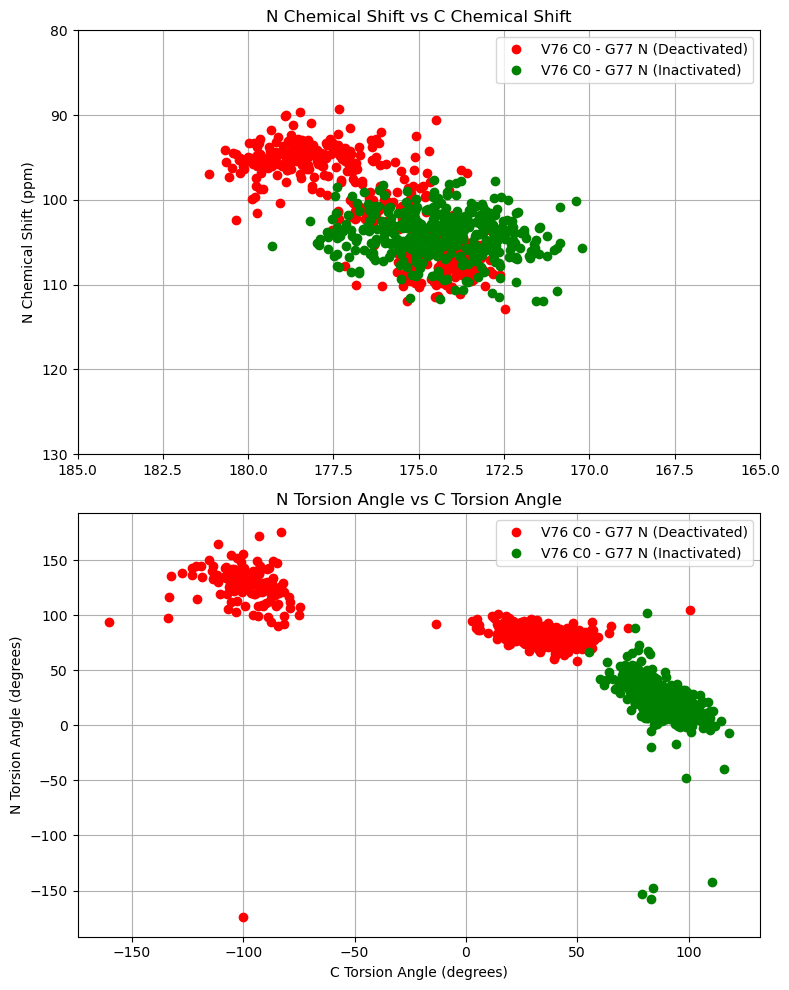

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create subplots without shared axes
fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=False, sharey=False)

# Plot N vs C Chemical Shifts
CO_in = np.array(V76_df_in[V76_df_in['atom'] == 'C']['iso'])
N_in = np.array(G77_df_in[G77_df_in['atom'] == 'N']['iso'])
CO_de_norm = np.array(V76_normal[V76_normal['atom'] == 'C']['iso'])
N_de_norm = np.array(G77_[G77_df_de['atom'] == 'N']['iso'])

axs[0].plot(CO_de, N_de, marker='o', linestyle='None', color='red', label='V76 C0 - G77 N (Norm Deactivated)')
axs[0].plot(CO_in, N_in, marker='o', linestyle='None', color='green', label='V76 C0 - G77 N (Inactivated)')
axs[0].set_ylabel('N Chemical Shift (ppm)')
axs[0].set_title('N Chemical Shift vs C Chemical Shift')
axs[0].set_xlim(185, 165)
axs[0].set_ylim(130, 80)
axs[0].legend()
axs[0].grid(True)

# Plot Torsion Angles
phi_de = np.array(V76_df_de[V76_df_de['atom'] == 'C']['torsion_angle_phi'])
psi_de = np.array(V76_df_de[V76_df_de['atom'] == 'C']['torsion_angle_psi'])
phi_in = np.array(V76_df_in[V76_df_in['atom'] == 'C']['torsion_angle_phi'])
psi_in = np.array(V76_df_in[V76_df_in['atom'] == 'C']['torsion_angle_psi'])

axs[1].plot(phi_de, psi_de, marker='o', linestyle='None', color='red', label='V76 C0 - G77 N (Deactivated)')
axs[1].plot(phi_in, psi_in, marker='o', linestyle='None', color='green', label='V76 C0 - G77 N (Inactivated)')
axs[1].set_xlabel('C Torsion Angle (degrees)')
axs[1].set_ylabel('N Torsion Angle (degrees)')
axs[1].set_title('N Torsion Angle vs C Torsion Angle')
axs[1].legend()
axs[1].grid(True)

# Adjust layout for better visual alignment
plt.tight_layout()
plt.show()


# plot the NCO CS and torsion angle in one plot

# Save the plots